In [1]:
import os
from pathlib import Path
import re

import librosa
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchaudio
import torchaudio.transforms as T
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

print(torch.__version__)
print(torchaudio.__version__)
print(f'Torch cuda enabled: {torch.cuda.is_available()}')



1.13.1+cu117
0.13.1+cu117
Torch cuda enabled: True


In [2]:
# Misc params

urban_root = Path('~/sound_datasets/urbansound8k').expanduser()
urban_metadata = urban_root / 'metadata/UrbanSound8K.csv'
urban_audio_path = urban_root / "audio/"

# Audio params

target_sample_rate = 22050
target_duration = 4
n_fft = 1024
hop_length = 512
n_mels = 60
len_ideal_wf = target_duration * target_sample_rate

# ML params

batch_size = 64
isShuffle = True
preview = True
epochs = 5

In [3]:
def numeric_to_human(classid):
    urbansound_labels = {
        0: "Air Conditioner",
        1: "Car Horn",
        2: "Children Playing",
        3: "Dog Bark",
        4: "Drilling",
        5: "Engine Idling",
        6: "Gun Shot",
        7: "Jackhammer",
        8: "Siren",
        9: "Street Music"
    }
    return urbansound_labels.get(classid, "Unkown Label")

In [4]:
# Return a list of maps like:
# [{train: [fold_1_training_data_paths], validation: [fold_1_validation_data_paths]}),
#  {train: [fold_2_training_data_paths], validation: [fold_2_validation_data_paths]}),
#  ...
#  {train: [fold_10_training_data_paths], validation: [fold_10_validation_data_paths]}),
# ]
def k_fold_urban_sound(metadata_path):
    """
    Extract the 10 recommended folds of UrbanSound8K
    
    Returns:
        a list of map folds in the form:
    [{train: [fold_1_training_data_paths], validation: [fold_1_validation_data_paths]}),
     {train: [fold_2_training_data_paths], validation: [fold_2_validation_data_paths]}),
     ...
     {train: [fold_10_training_data_paths], validation: [fold_10_validation_data_paths]}),
     ]
        
    """
    folds = []
    frame = pd.read_csv(metadata_path)
    frame.info()
    
    print("\nSummarizing folds:")
    print('-----------------------------------------------------------')
    for i in range(1,11):
        train_mask = frame['fold'] != i
        validation_mask = frame['fold'] == i
        # TODO: Duration mask?
        
        print(f'Training set size for fold {i} : {len(frame[train_mask])}')
        train = frame[train_mask]
        print(f"Training set info: \n")
        examine_urban_sound_df(train)
        
        print(f'Validation set size for fold {i} : {len(frame[validation_mask])}')
        validation = frame[validation_mask]
        print(f"Validation set info: \n")
        examine_urban_sound_df(validation)
        
        train_paths = train.apply(lambda r: f"fold{r['fold']}/{r['slice_file_name']}", axis=1)
        validation_paths = validation.apply(lambda r: f"fold{r['fold']}/{r['slice_file_name']}", axis=1)
        
        folds.append({"train": train_paths.tolist(), "validation": validation_paths.tolist()})
        print('-----------------------------------------------------------')
    print("\n\n")
    
    return folds

In [5]:
def examine_urban_sound_df(df):
    df_copy = df.copy()
    total = len(df_copy)
    
    print(f"Total samples: {total}")
    print(f"{'Class':<16} | {'Frequency':<10} | {'Percentage':<10}")
    print("-" * 40)
    
    distribution = df_copy['class'].value_counts()
    for cls, freq in distribution.items():
        percentage = (freq / total) * 100
        print(f"{cls:<16} | {freq:<10} | {percentage:.2f}%")
    print("-" * 40 + "\n")
    
    df_copy["duration"] = df_copy["end"] - df_copy["start"]
    print(f"Duration statistics: \n{df_copy['duration'].describe()}")
    

In [6]:
folds = k_fold_urban_sound(urban_metadata)

df = pd.read_csv(urban_metadata)
examine_urban_sound_df(df)

#TODO: Examine each fold

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   fsID             8732 non-null   int64  
 2   start            8732 non-null   float64
 3   end              8732 non-null   float64
 4   salience         8732 non-null   int64  
 5   fold             8732 non-null   int64  
 6   classID          8732 non-null   int64  
 7   class            8732 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 545.9+ KB

Summarizing folds:
-----------------------------------------------------------
Training set size for fold 1 : 7859
Training set info: 

Total samples: 7859
Class            | Frequency  | Percentage
----------------------------------------
engine_idling    | 904        | 11.50%
dog_bark         | 900        | 11.45%
children_playing | 900        | 11.45%
air_conditio

Duration statistics: 
count    936.000000
mean       3.553224
std        1.032612
min        0.179305
25%        4.000000
50%        4.000000
75%        4.000000
max        4.000000
Name: duration, dtype: float64
-----------------------------------------------------------
Training set size for fold 6 : 7909
Training set info: 

Total samples: 7909
Class            | Frequency  | Percentage
----------------------------------------
jackhammer       | 932        | 11.78%
dog_bark         | 900        | 11.38%
children_playing | 900        | 11.38%
air_conditioner  | 900        | 11.38%
street_music     | 900        | 11.38%
drilling         | 900        | 11.38%
engine_idling    | 893        | 11.29%
siren            | 855        | 10.81%
car_horn         | 401        | 5.07%
gun_shot         | 328        | 4.15%
----------------------------------------

Duration statistics: 
count    7909.000000
mean        3.608685
std         0.970717
min         0.054517
25%         4.000000
50%      

In [7]:
print(folds[0]['train'][:5])
print(folds[0]['validation'][:5])

['fold5/100032-3-0-0.wav', 'fold5/100263-2-0-117.wav', 'fold5/100263-2-0-121.wav', 'fold5/100263-2-0-126.wav', 'fold5/100263-2-0-137.wav']
['fold1/101415-3-0-2.wav', 'fold1/101415-3-0-3.wav', 'fold1/101415-3-0-8.wav', 'fold1/102106-3-0-0.wav', 'fold1/102305-6-0-0.wav']


In [8]:
class Rescale(object):
    """Rescale an audio signal to given length via cropping or padding
    
    Args:
        output_size (int): Desired output size.
    """
    
    def __init__(self, output_size):
        self.output_size = output_size
        assert isinstance(output_size, int)
    
    def __call__(self, waveform):
        waveform = torch.squeeze(waveform)
        assert waveform.ndim <= 2
        
        # TODO: Pull stereo / mono into new class?
        
        ret_wf = None
        if waveform.ndim == 1:
            waveform = torch.stack((waveform, waveform))
#             if len(waveform) < self.output_size:
#                 ret_wf = F.pad(waveform, (0, self.output_size-len(waveform)))
#             elif len(waveform) > self.output_size:
#                 ret_wf = waveform[:self.output_size]
#         else: # Stereo

        if len(waveform[0]) < self.output_size:
            ret_wf = F.pad(waveform, (0, self.output_size-len(waveform[0]), 0, 0))
        elif len(waveform[0]) > self.output_size:
            expanded_l = waveform[0][:self.output_size]
            expanded_r = waveform[1][:self.output_size]
            ret_wf = torch.stack((expanded_l, expanded_r))
        else:
            ret_wf = waveform
        
        return ret_wf

In [9]:
class UrbanSoundDataSet(Dataset):
    def __init__(self, urban_audio_path, relativepaths, transform=None, sample_rate = None):
        self.sounds = list({urban_audio_path/path for path in relativepaths})
        self.resampled_sample_rate = sample_rate
        self.transform = transform
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        sound_fp = self.sounds[idx]
        label = re.search(r'\d+-(\d)-\d+-\d+\.wav$', str(sound_fp)).group(1)
        
        # normalize here is converting native sample type to f32
        waveform, native_sample_rate = torchaudio.load(sound_fp, normalize=True)

        transforms = [
            T.Resample(native_sample_rate, self.resampled_sample_rate),
            Rescale(len_ideal_wf),
            T.MelSpectrogram()
        ]
        for t in transforms:
            waveform = t(waveform)
        
        mel_spectrogram = waveform
            
        sample = {"spectrogram": mel_spectrogram, "label": label}
        
        return sample
        
    def __len__(self):
        return len(self.sounds)

In [10]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")

In [11]:
print(f"{len(folds)}-fold cross validation training")
print("-"*34)

fold_results = []
for fold_idx, fold_bundle in enumerate(folds):
    print(f"Fold {fold_idx}:")
    train_ds = UrbanSoundDataSet(urban_audio_path, fold_bundle['train'], sample_rate=target_sample_rate)
    validation_ds = UrbanSoundDataSet(urban_audio_path, fold_bundle['validation'], sample_rate=target_sample_rate)
    print(f"\tSize of train, val datasets: {(len(train_ds), len(validation_ds))}")
    
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=isShuffle)
    validation_dl = DataLoader(validation_ds, batch_size=batch_size, shuffle=isShuffle)
    
    if preview:
        sample = next(iter(train_dl))
        spctrs, labels = sample['spectrogram'], sample['label']
        fold_results.append((spctrs, labels))


10-fold cross validation training
----------------------------------
Fold 0:
	Size of train, val datasets: (7859, 873)


/home/lucaskeller/anaconda3/envs/ai2024-audio/lib/python3.10/site-packages/torchaudio/functional/functional.py:571: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Fold 1:
	Size of train, val datasets: (7844, 888)
Fold 2:
	Size of train, val datasets: (7807, 925)
Fold 3:
	Size of train, val datasets: (7742, 990)
Fold 4:
	Size of train, val datasets: (7796, 936)
Fold 5:
	Size of train, val datasets: (7909, 823)
Fold 6:
	Size of train, val datasets: (7894, 838)
Fold 7:
	Size of train, val datasets: (7926, 806)
Fold 8:
	Size of train, val datasets: (7916, 816)
Fold 9:
	Size of train, val datasets: (7895, 837)


10


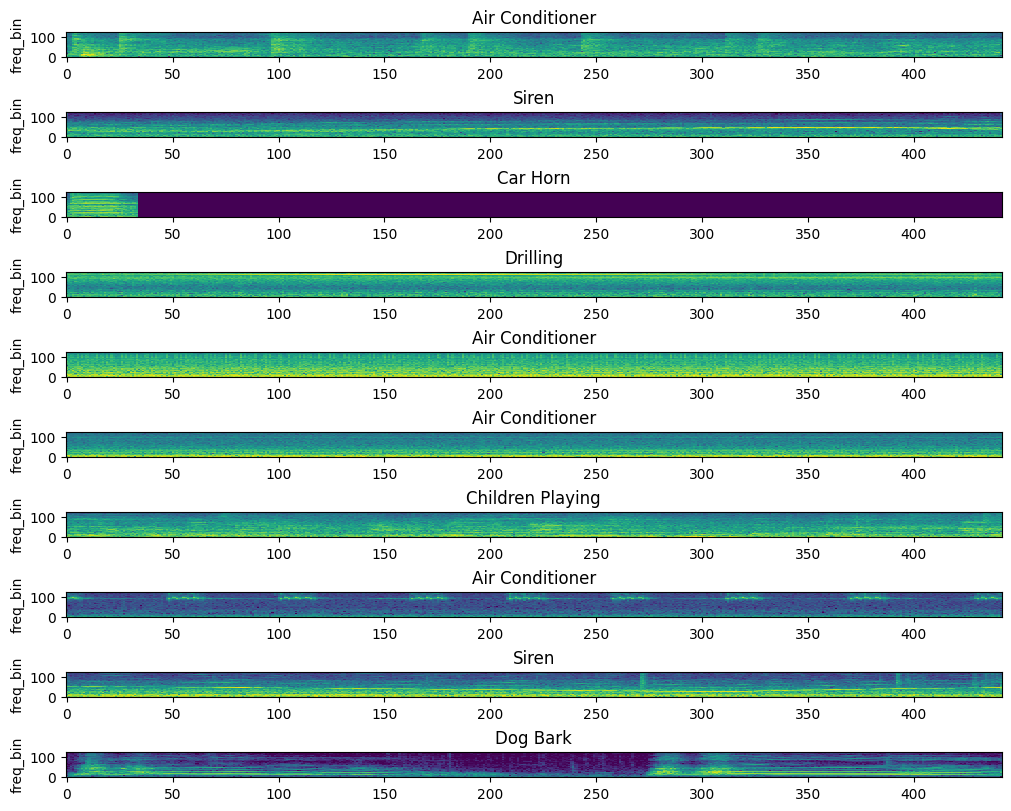

In [12]:
# Visualization Block

fig, axs = plt.subplots(len(folds), 1, figsize=(10,8), constrained_layout=True)
print(len(fold_results))
for fold_idx, (spctr, label) in enumerate(fold_results):
    plot_spectrogram(spctr[0][0], numeric_to_human(int(label[0])), ax=axs[fold_idx])

plt.show()

In [13]:
class SimpleClassifier(torch.nn.Module):
    def __init__(self):
        super()
    
    def forward(x):
        return 0